# Are Pitchers Good Batters?

*Author: Nate Reed*  
*Date: August 18, 2016*

The Lahman Baseball Database (available here: http://www.seanlahman.com/baseball-archive/statistics/) provides an extensive historical database of baseball statistics which I will use to answer the following interesting questions:

* Have batting averages increased or decreased over time?
* Is there a relationship between batting and pitching skills?
* Of those pitchers who bat, are pitchers good batters? 

This report uses some informal techniques (eg. exploratory data analysis) and basic statistics to find answers to these questions. 

# Part 1: Preliminaries
## 1.1 Obtain the Data


In [10]:
import urllib.request as request
request.urlretrieve('http://seanlahman.com/files/database/baseballdatabank-master_2016-03-02.zip', "baseballdatabank-master_2016-03-02.zip")

from zipfile import ZipFile
zip = ZipFile('baseballdatabank-master_2016-03-02.zip')
zip.extractall()

## 1.2 Load the Batting Data


In [50]:
import pandas as pd

batting_df = pd.read_csv("baseballdatabank-master\core\Batting.csv")
print("%d observations" % len(batting_df))

101332 observations


In [51]:
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,...,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,...,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,...,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


The data is indexed by playerID, yearID and teamID. Each entry contains the aggregate statistics for a player's stint on a team. A player can have multiple stints per year. 

## 1.3 Select columns for analysis:

To understand batting, we will look at one of the common metrics for batting ability, the batting average, which is calculated as Hits / "At Bat's". I will select the stint and the team, in addition to hits and "at bats":


In [52]:
batting_df = batting_df[['playerID', 'yearID', 'AB', 'H', 'stint', 'teamID', 'lgID']]
batting_df.head(5)

,playerID,yearID,AB,H,stint,teamID,lgID
0,abercda01,1871,4.0,0.0,1,TRO,NaN
1,addybo01,1871,118.0,32.0,1,RC1,NaN
2,allisar01,1871,137.0,40.0,1,CL1,NaN
3,allisdo01,1871,133.0,44.0,1,WS3,NaN
4,ansonca01,1871,120.0,39.0,1,RC1,NaN



## 1.4 Calculate Batting Average

In [53]:
batting_df['batting_average'] = batting_df['H'] / batting_df['AB']
batting_df.head(5)

,playerID,yearID,AB,H,stint,teamID,lgID,batting_average
0,abercda01,1871,4.0,0.0,1,TRO,NaN,0.000000
1,addybo01,1871,118.0,32.0,1,RC1,NaN,0.271186
2,allisar01,1871,137.0,40.0,1,CL1,NaN,0.291971
3,allisdo01,1871,133.0,44.0,1,WS3,NaN,0.330827
4,ansonca01,1871,120.0,39.0,1,RC1,NaN,0.325000


## 1.5 Examine the Distribution

We will look at the distribution of data to see if we notice any interesting anything interesting. First, we look at the distribution of batting averages, which we plot below in the density plot.

In [54]:
batting_df['batting_average'].dropna().describe()

count    86410.000000
mean         0.209025
std          0.122313
min          0.000000
25%          0.147541
50%          0.230769
75%          0.274434
max          1.000000
Name: batting_average, dtype: float64

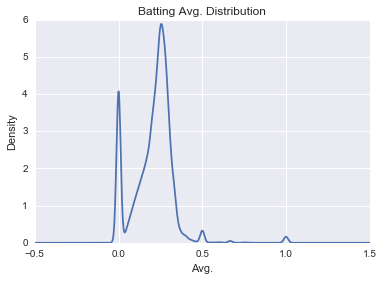

C:\Users\Owner\Anaconda3\envs\data_analysis\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning:

Invalid value encountered in percentile



0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: lgID, dtype: object

In [55]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# Plot the distribution
batting_df['batting_average'].plot.kde()
plt.title("Batting Avg. Distribution")
plt.xlabel("Avg.")
plt.show()

batting_df.describe()
batting_df['lgID'].head()

This is an interesting distribution. It doesn't quite look normal, as quite a few batters have zero averages. Also, there are a few with unusually high averages (50% and 100%). 

## 1.6 Exploratory Analyis: Batting Average over time

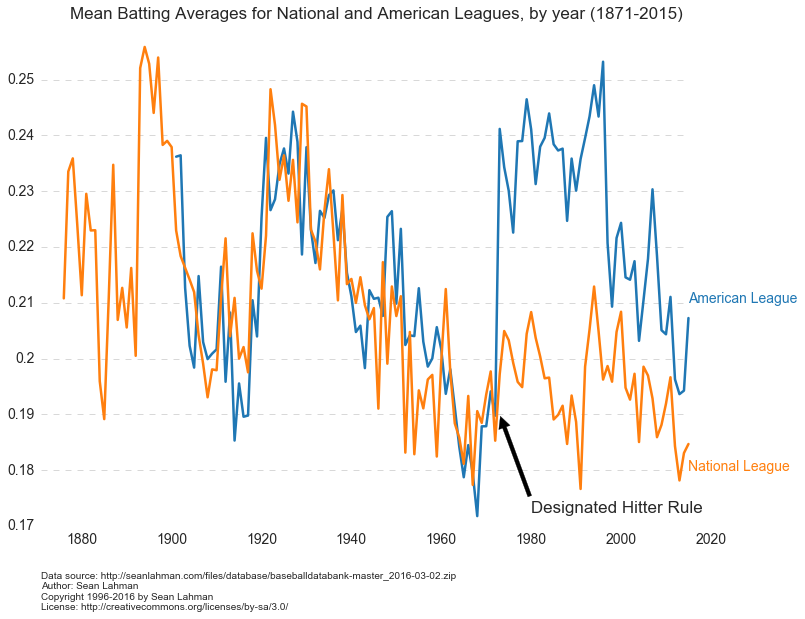

In [56]:
import numpy as np

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

def apply_common_chart_style():
    plt.figure(figsize=(12, 9))   
    # Remove the plot frame lines. They are unnecessary chartjunk.    
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)

    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()   

    ax.set_axis_bgcolor("white")

plt.figure(figsize=(12, 9))   
    # Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   

ax.set_axis_bgcolor("white")
    
#apply_common_chart_style()

# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(.17, 0.26)    
plt.xlim(1871, 2020) 

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(np.arange(17, 26) / 100, [str(x/100) for x in np.arange(17, 26)], fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in np.arange(17, 26) / 100:    
    plt.plot(range(1871, 2015), [y] * len(range(1871, 2015)), "--", lw=0.5, color="black", alpha=0.3)    
    
# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
  
# American League
averages = batting_df[batting_df['lgID'] == 'AL'].groupby('yearID')['batting_average'].mean()
plt.plot(averages.index, averages, lw=2.5, color=tableau20[0])

# National League
averages = batting_df[batting_df['lgID'] == 'NL'].groupby('yearID')['batting_average'].mean()
plt.plot(averages.index, averages, lw=2.5, color=tableau20[2])

plt.text(2015, 0.21, "American League", fontsize=14, color=tableau20[0])  
plt.text(2015, 0.18, "National League", fontsize=14, color=tableau20[2])  

plt.title("Mean Batting Averages for National and American Leagues, by year (1871-2015)",
         fontsize=17, ha="center")

plt.text(1871, 0.155, "Data source: http://seanlahman.com/files/database/baseballdatabank-master_2016-03-02.zip"   
                   "\nAuthor: Sean Lahman"
                   "\nCopyright 1996-2016 by Sean Lahman"
                   "\nLicense: http://creativecommons.org/licenses/by-sa/3.0/", fontsize=10)    
      
ax.annotate('Designated Hitter Rule', xy=(1973, .19), xytext=(1980, 0.1725),
            arrowprops=dict(facecolor='black', shrink=0.02),
            fontsize=17)

plt.savefig("batting-averages-by-league-time-series-annotated.png", bbox_inches="tight")  
plt.show()

There are some interesting changes in batting average over time. There was a spike leading up to the 1890's, followed by a steep decline, then a couple spikes leading up to a peak in the 1920's, followed by a long, slow decline into the 1960's. After that batting averages trended up into the 80's and to year 2000. We might want to explore why this happened using other data in our data set, but that is outside the scope of this initial investigation.

# Part 2: Batting Skills vs. Pitching Skills

Pitching skill is measured by a few different stats, but one of the most common is Earned Run Average, or ERA. The ERA is calculated as the number of Earned Runs divided by the number of innings pitched. The definition of "Earned Run" is rather long. In short, it is a run for which the pitcher is held accountable (See http://www.baseball-almanac.com/rule10.shtml#anchor11198 for the full definition).

The variable "IPouts" is the number of innings pitched times 3. We can get the number of innings pitched simply by dividing this number by 3.

For batting, we refer to the batting average, although there are other statistics we could consider. For brevity, I just use the batting average we calculated above

## 2.1 Get Pitching Data

In [57]:
import pandas as pd
pitching_df = pd.read_csv("baseballdatabank-master\core\Pitching.csv")

## 2.2 Calculate Earned Run Average 

In [58]:
pitching_df['innings_pitched'] = pitching_df['IPouts'] / 3
pitching_df['ERA'] = pitching_df['ER'] / pitching_df['innings_pitched'] * 9
pitching_df = pitching_df[['playerID', 'yearID', 'stint', 'teamID', 'IPouts', 'ER', 'ERA', 'innings_pitched']]
pitching_df.head()

,playerID,yearID,stint,teamID,IPouts,ER,ERA,innings_pitched
0,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0
1,brainas01,1871,1,WS3,792.0,132,4.500000,264.0
2,fergubo01,1871,1,NY2,3.0,3,27.000000,1.0
3,fishech01,1871,1,RC1,639.0,103,4.352113,213.0
4,fleetfr01,1871,1,NY2,27.0,10,10.000000,9.0


In [59]:
pitching_df = pitching_df.dropna() # Drop missing values
pitching_df.describe()

,yearID,stint,IPouts,ER,ERA,innings_pitched
count,44083.000000,44083.000000,44083.000000,44083.000000,4.408300e+04,44083.000000
mean,1967.818547,1.079305,255.992877,36.367171,inf,85.330959
std,37.345478,0.284530,258.432048,33.532416,NaN,86.144016
min,1871.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1940.000000,1.000000,50.000000,9.000000,3.151867e+00,16.666667
50%,1977.000000,1.000000,169.000000,25.000000,4.133201e+00,56.333333
75%,2000.000000,1.000000,398.000000,58.000000,5.500000e+00,132.666667
max,2015.000000,4.000000,2040.000000,291.000000,inf,680.000000


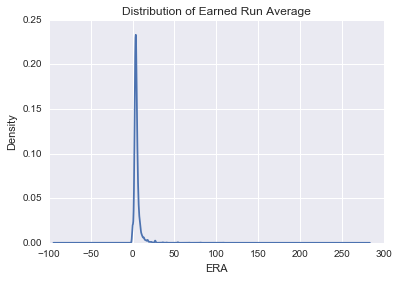

In [60]:
import numpy as np
pitching_df[np.isfinite(pitching_df['ERA'])]['ERA'].plot.kde()
plt.title('Distribution of Earned Run Average')
plt.xlabel('ERA')
plt.show()

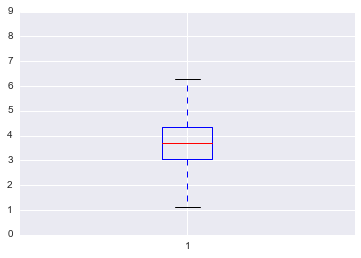

In [61]:
data = pitching_df[pitching_df['innings_pitched'] > 100]
data = data['ERA']
data.describe()
plt.boxplot([data])
plt.show()

# The variance is so high that a box plot 

In the above plot, there is a wide range of values, but most observations are between 0 and 5. A "good" ERA is below 4. Between 4 and 5 is OK, but not great. Over 5 is considered unsustainable, as a pitcher with this ERA will likely be replaced.

For this analysis, I am interested in all skill levels. Like the batters, some of these pitchers have exceptionally good or bad metrics, mostly due to a small number of games pitched. For the scatterplot below, I've included those outliers. In addition, I will re-load the batters and include those batters with few at bats. Skills are likely correlated with the number of attempts, as players who perform poorly will be given fewer opportunities.

## 2.3 Merge Pitching and Batting 

In [62]:
players_df = pd.merge(pitching_df, batting_df, on="playerID", how="inner")
players_df = players_df[players_df['AB'] > 0] # Require at least 1 at bat
players_df = players_df[players_df['innings_pitched'] > 0] # Eliminate no innings pitched
players_df.describe()

players_df.head()

,playerID,yearID_x,stint_x,teamID_x,IPouts,ER,ERA,innings_pitched,yearID_y,AB,H,stint_y,teamID_y,lgID,batting_average
0,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0,1871,94.0,33.0,1,PH1,NaN,0.351064
1,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0,1872,248.0,74.0,1,NY2,NaN,0.298387
2,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0,1873,258.0,63.0,1,PH2,NaN,0.244186
3,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0,1874,151.0,42.0,1,PH2,NaN,0.278146
4,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0,1875,61.0,17.0,1,PH3,NaN,0.278689


## 2.4 Pitching vs. Batting

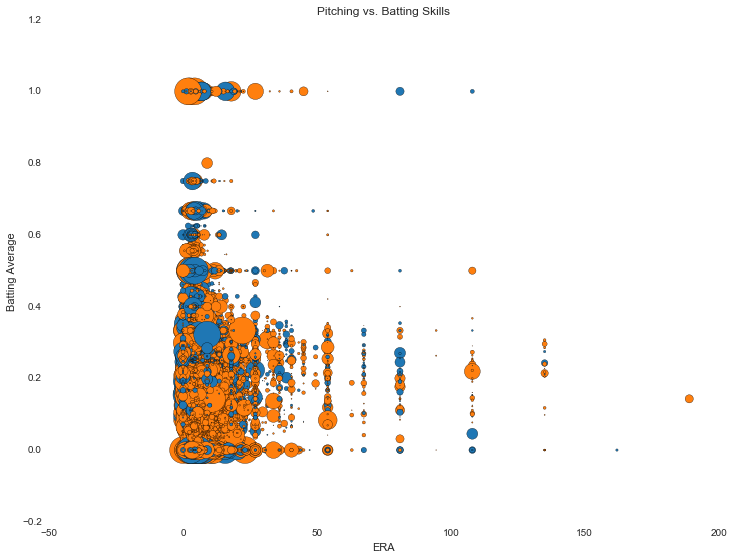

In [63]:
apply_common_chart_style()

players_df = players_df.dropna()
players_df = players_df[players_df['lgID'].isin(['NL', 'AL'])]
    
# Drop leagues other than National, American 
player_ids = players_df['playerID'].unique() 
pgb = players_df.groupby('playerID')
eras = pgb['ER'].sum().values / pgb['innings_pitched'].sum().values
batting_averages = pgb['H'].sum().values / pgb['AB'].sum().values

ip_counts = players_df.groupby('playerID')['innings_pitched'].sum().values
ab_counts = players_df.groupby('playerID')['AB'].sum().values

summary_df = pd.DataFrame({'playerID' : player_ids,
                           'ip_counts' : ip_counts,
                           'ab_counts' : ab_counts,
                           'ERA' : eras,
                           'batting_average' : batting_averages})
summary_df = summary_df[summary_df['ip_counts'] > 1000]
summary_df = summary_df[summary_df['ab_counts'] > 1000]
counts = summary_df['ip_counts'] + summary_df['ab_counts']

scaled_counts = counts / (max(counts) - min(counts))  
bubble_size = np.pi * (scaled_counts * 15) **2       # 0 to 15 pt radiuses

#TBD: Remove other leagues
league_colors = players_df.apply(lambda row: tableau20[2] if row['lgID'] == 'NL' else tableau20[0], axis=1)

plt.scatter(players_df['ERA'], 
            players_df['batting_average'],
            s=bubble_size,
            c=league_colors)
#s=bubble_size,
plt.title('Pitching vs. Batting Skills')
plt.xlabel('ERA')
plt.ylabel('Batting Average')
plt.show()


Most of the values are clustered between 0 to 10.0 ERA, and 0 to 0.4 batting average. It is hard to discern any clear relationship between great batting averages and pitching skill using this plot. Also, we see quite a few outliers. 

# Part 3: Are Pitchers Good Batters?

The "Designated Hitter" rule allows a team to use one non-fielding player as a batter, typically in place of the pitcher. This rule was introduced in 1973 in the American League. In the Lahmann database, Appearances.G_dh is the number of games as designated hitter. 

The common understanding is that pitchers are not typically good at batting. This makes me curious: can we quantify how poorly pitchers perform in comparison to other players at batting?
    
To compare their respective batting skills, we will divide the batters into two groups -- those who have pitched, and those who haven't. 


## 3.1 Remove Anomalous Data

Some of these values should not be included in analysis because they're not representative of the populations we want to compare. For example, some players that batted relatively few times had unusually low or high averages. There is a disproportionate number of such entries in the Batting data, as we saw in section 1.5, which skews the distribution. We will throw those values out:


In [64]:
players_df = players_df[players_df['AB'] > 20]
batting_df = batting_df[batting_df['AB'] > 20]

## 3.2 Subset Batters

In [65]:
# Population 1: Pitchers that also bat

players_df = players_df[players_df['AB'] > 100]
batting_df = batting_df[batting_df['AB'] > 100]

pitchers_that_bat = players_df[players_df['innings_pitched'] > 100.0]

pitchers_that_bat_grouped_by_playerID = pitchers_that_bat.groupby('playerID', as_index=False)
batting_averages_for_pitchers = pitchers_that_bat_grouped_by_playerID.sum()['H'] / pitchers_that_bat_grouped_by_playerID.sum()['AB']
print("Batting pitchers: %d" % len(batting_averages_for_pitchers))

# Population 2: All other batters
non_pitching_batters = batting_df[~batting_df['playerID'].isin(pitchers_that_bat['playerID'])]
non_pitching_batters = non_pitching_batters[non_pitching_batters['AB'] > 20]
non_pitching_batters_grouped_by_playerID = non_pitching_batters.groupby('playerID', as_index=False)
batting_averages_for_non_pitchers = non_pitching_batters_grouped_by_playerID.sum()['H'] / non_pitching_batters_grouped_by_playerID.sum()['AB']
print("All other batters: %d" % len(batting_averages_for_non_pitchers))


Batting pitchers: 461
All other batters: 6244


Boxplot of each group:

In [76]:
import plotly.plotly as py
import plotly.graph_objs as go

#data = [batting_averages_for_pitchers, batting_averages_for_non_pitchers]
x_data = ['Pitchers', 'Non-Pitchers']
y_data = [batting_averages_for_pitchers, batting_averages_for_non_pitchers]
traces = []
colors = [tableau20[0], tableau20[1]]

for i in range(2):
    yd = y_data[i]
    xd = x_data[i]
    cls = colors[i]
    traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))
    
layout = go.Layout(
    title='Batting Averages',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=.1,
        gridcolor='rgb(243, 243, 243)',
        gridwidth=1,
        zerolinecolor='rgb(243, 243, 243)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 255, 255)',
    showlegend=False
)
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)


## 3.3 Compare means

We look at the mean batting average for pitchers that bat vs. all other batters:

In [67]:
batting_averages_for_pitchers.mean()

0.21132686222482638

In [68]:
batting_averages_for_non_pitchers.mean()

0.25372779678527918

It does appear, at first blush, that pitchers are worse at batting based on the means we calculated for both groups. We can use a t-test to test the null hypothesis that batting pitchers bat no better or worse than all other batters.

The t-test assumes a normal distribution. Recall that we observed outliers in the baseball averages due to players that infrequently batted and had either very low or very high batting averages. Similarly, some pitchers pitched few innings. We removed those outliers in section 3.1 in order to get a more accurate confidence interval for the t-test:


## 3.4 Hypothesis Test

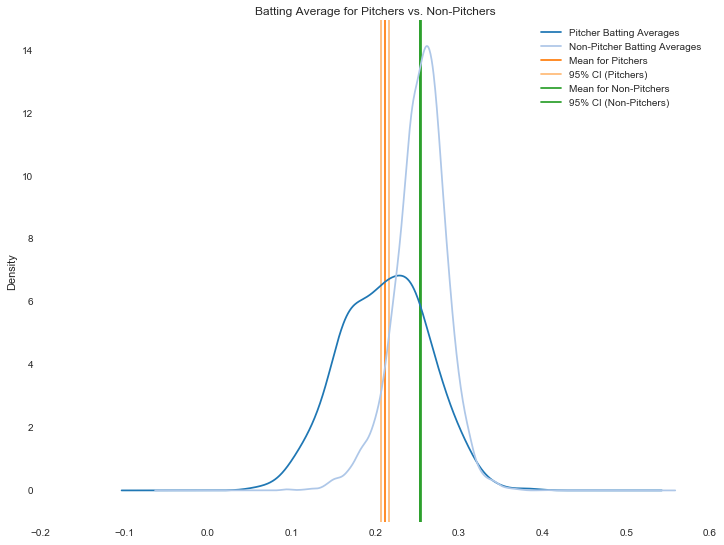

In [99]:
import scipy.stats as st

stderr = st.sem(batting_averages_for_pitchers)
interval1 = (batting_averages_for_pitchers.mean() - stderr * 1.96, batting_averages_for_pitchers.mean() + stderr * 1.96)

stderr = st.sem(batting_averages_for_non_pitchers)
interval2 = (batting_averages_for_non_pitchers.mean() - stderr * 1.96, batting_averages_for_non_pitchers.mean() + stderr * 1.96)


plt.figure(figsize=(12, 9))   
    # Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   

batting_averages_for_pitchers.plot.kde(label="Pitcher Batting Averages", color=tableau20[0])
ax = batting_averages_for_non_pitchers.plot.kde(label="Non-Pitcher Batting Averages", color=tableau20[1])

# Pitchers
ax.vlines(x=batting_averages_for_pitchers.mean(), ymin=-1, ymax=15, color=tableau20[2], label='Mean for Pitchers')
ax.vlines(x=interval1[0], ymin=-1, ymax=15, color=tableau20[3], label='95% CI (Pitchers)')
ax.vlines(x=interval1[1], ymin=-1, ymax=15, color=tableau20[3])

# Non-Pitchers
ax.vlines(x=batting_averages_for_non_pitchers.mean(), ymin=-1, ymax=15, color=tableau20[4], label='Mean for Non-Pitchers')
ax.vlines(x=interval2[0], ymin=-1, ymax=15, color=tableau20[4], label='95% CI (Non-Pitchers)')
ax.vlines(x=interval2[1], ymin=-1, ymax=15, color=tableau20[4])

ax.set_ylim([-1,15])
ax.legend()
ax.set_axis_bgcolor('white')
# color="black", alpha=0.3
ax.tick_params(axis='x', color="black")
#ax.tick_params(axis='y',)

plt.title("Batting Average for Pitchers vs. Non-Pitchers")
plt.savefig("batting-averages-t-test.png", bbox_inches="tight")  

#for y in np.arange(0, 14) / 100:
#    x = [x/10 for x in range(-1,5)]
#    plt.plot(x, [y] * 0.6, "--", lw=0.5, color="black", alpha=0.3)    
    
plt.show()

We see that the confidence intervals for the mean batting average of each population do not overlap. We will confirm this with a t-test below:

In [70]:
import scipy.stats

scipy.stats.ttest_ind(batting_averages_for_pitchers, batting_averages_for_non_pitchers, equal_var=False)

Ttest_indResult(statistic=-17.236132046967263, pvalue=2.6824567762210891e-52)

Since the p-value is very small, we can reject the null hypothesis. The mean batting average for pitchers is clearly lower than the mean batting average for all other players.